In [72]:
import numpy as np 
import pandas as pd 
import seaborn as sns

# Explore Data

In [73]:
data = pd.read_csv('train.csv')
data

,word,label
0,finalmente,spanish
1,secar,spanish
2,aprendio,spanish
3,entrenamiento,spanish
4,suave,spanish
...,...,...
1195,milieu,french
1196,entierement,french
1197,quand,french
1198,doree,french


### Is it clean?

In [74]:
data.groupby('label').count()

,word
label,
french,600
spanish,600


In [75]:
data.isna().sum()

word     0
label    0
dtype: int64

### How many letters are there?

In [76]:
words = data.word.unique()
# Initialize an empty set to store unique letters
unique_letters = set()

# Iterate over each word in the array
for word in words:
    # Add each letter in the current word to the set
    unique_letters.update(word)

# The 'unique_letters' set now contains all unique letters
print(f'unique letters: {unique_letters}')
print(f'count: {len(unique_letters)}')

unique letters: {'w', 'k', 'g', 'l', 's', 'i', 'a', 'p', 'v', 'f', 'j', 'e', 'r', 'o', 'b', 'x', 't', 'z', 'h', 'n', 'q', 'c', 'm', 'u', 'd', 'y'}
count: 26


### What is the longest word in the dataset?

In [77]:
word_lengths = data.word.apply(lambda x: len(x))
print(f'longest word: {data.word[word_lengths.idxmax()]}, is {word_lengths.max()} letters')

longest word: involontairement, is 16 letters


### What are letter frequencies by language

In [111]:
from collections import Counter

# Assuming 'data' is a DataFrame with columns 'word' and 'label' representing the word and its language respectively

# Step 1: Flatten the list of letters by language
letters_by_lang = data.apply(
    lambda row: [(letter, row['label']) for letter in row['word']], 
    axis=1
).explode()

# Step 2: Count the frequency of each letter by language
letter_freq = Counter(letters_by_lang)

# Convert the counter object to a list of tuples and then to a DataFrame
letter_freq_df = pd.DataFrame(
    list(letter_freq.items()), 
    columns=['letter_lang', 'freq']
)

# Split the combined letter and language column into separate columns
letter_freq_df[['letter', 'language']] = pd.DataFrame(
    letter_freq_df['letter_lang'].tolist(), index=letter_freq_df.index)
letter_freq_df.drop(columns=['letter_lang'], inplace=True)

# Step 3: Group by language and letter, and sum the frequencies
letter_freq_grouped = letter_freq_df.groupby(['language', 'letter']) \
    .sum().reset_index()

# Step 4: Calculate the total letter count by language
total_letter_count_by_lang = letter_freq_grouped.groupby('language')['freq'] \
    .sum().reset_index().rename(columns={'freq': 'total_freq'})

# Step 5: Merge the total count back to the main DataFrame to have the total frequency available for normalization
letter_freq_final = letter_freq_grouped.merge(
    total_letter_count_by_lang, 
    on='language'
)

# Step 6: Normalize the frequencies by the total count of letters for each language
letter_freq_final['normalized_freq'] = (
    letter_freq_final['freq'] / letter_freq_final['total_freq']
)

# Uncomment to display the final DataFrame (in an actual script, replace this with a print or other display function)
letter_freq_final.head()

# The final DataFrame 'letter_freq_final' contains the language, letter, frequency, total frequency for the language, and normalized frequency


,language,letter,freq,total_freq,normalized_freq
0,french,a,379,4538,0.083517
1,french,b,56,4538,0.012340
2,french,c,168,4538,0.037021
3,french,d,91,4538,0.020053
4,french,e,757,4538,0.166814


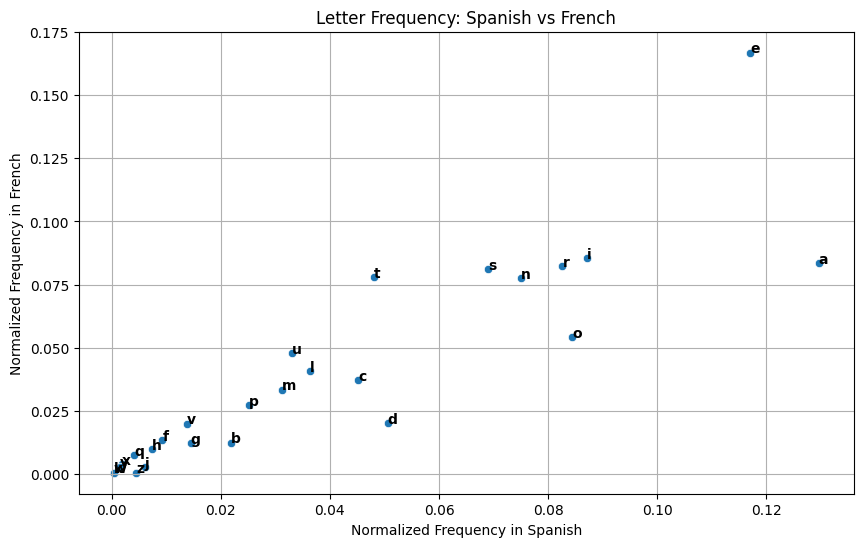

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'pivot_df' is the DataFrame with letters as index and normalized frequencies for Spanish and French as columns

# Step 2: Plotting with Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pivot_df, x='spanish', y='french')

# Step 3: Annotating Points
for letter, row in pivot_df.iterrows():
    plt.text(row['spanish'], row['french'], letter, horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.title('Letter Frequency: Spanish vs French')
plt.xlabel('Normalized Frequency in Spanish')
plt.ylabel('Normalized Frequency in French')
plt.grid(True)

# Display the plot
plt.show()


### Explore Vectorization 

In [174]:
def letter_freq_vec(word):
    letter_ref = {letter:i for i, letter in enumerate('abcdefghijklmnopqrstuvwxyz')}
    vec = np.zeros(26)
    for letter in word:
        vec[letter_ref[letter]] += 1
    return vec / len(word)

X = np.vstack(data.word.apply(letter_freq_vec))
y = data.label
X

array([[0.1  , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.2  , 0.   , 0.2  , ..., 0.   , 0.   , 0.   ],
       [0.125, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.2  , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]])

In [182]:
def word_to_vec(word):
    letter_ref = {letter:i for i, letter in enumerate('abcdefghijklmnopqrstuvwxyz')}
    vec = np.zeros(26)
    for i in range(len(word)):
        vec[i] = letter_ref[word[i]]
    return vec 

X = np.vstack(data.word.apply(word_to_vec))
y = data.label
X

array([[ 5.,  8., 13., ...,  0.,  0.,  0.],
       [18.,  4.,  2., ...,  0.,  0.,  0.],
       [ 0., 15., 17., ...,  0.,  0.,  0.],
       ...,
       [16., 20.,  0., ...,  0.,  0.,  0.],
       [ 3., 14., 17., ...,  0.,  0.,  0.],
       [ 3.,  4., 15., ...,  0.,  0.,  0.]])

In [185]:
def letter_count_vec(word):
    letter_ref = {letter:i for i, letter in enumerate('abcdefghijklmnopqrstuvwxyz')}
    
    vec = np.zeros(26)
    for letter in word:
        vec[letter_ref[letter]] += 1
    return vec

X = np.vstack(data.word.apply(letter_count_vec))
y = data.label
X

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [580]:
import itertools
import string
import re

# Generate all possible combinations of 2 letters from the alphabet
combinations = itertools.product(string.ascii_lowercase+'<>', repeat=2)
pairs_ref = {}
for i, combination in enumerate(combinations, start=0):  
    combination_str = ''.join(combination)
    pairs_ref[combination_str] = i


combinations = itertools.product(string.ascii_lowercase, repeat=3)
tripples_ref = {}
for i, combination in enumerate(combinations, start=0): 
    combination_str = ''.join(combination)
    tripples_ref[combination_str] = i


def count_double_letters(word):
    # Regular expression pattern to find double letters
    pattern = r"(.)\1"
    matches = re.findall(pattern, word)
    return len(matches)


def vowel_proportion(word):
    # Regular expression pattern to find vowels (a, e, i, o, u)
    # Adding 'y' as a vowel as well, though it's sometimes considered a vowel
    pattern = r"[aeiouyAEIOUY]"
    
    # Find all vowels in the word
    vowels = re.findall(pattern, word)
    vowel_count = len(vowels)
    total_letters = len(word)
    
    proportion = vowel_count / max(total_letters, 1)
    
    return proportion


def pair_count_vec(word):
    vec = np.zeros(len(pairs_ref)+3)
    # vec[-5] = tripples_ref[word[:3]]
    vec[-2] = tripples_ref[word[-3:]]
    # vec[-2] = vowel_proportion(word)
    vec[-1] = count_double_letters(word)

    word = f'<{word}>'
    for i in range(1, len(word)):
        index = pairs_ref[word[i-1:i+1]]
        vec[index] += 1
    return vec

X = np.vstack(data.word.apply(pair_count_vec))
y = data.label
X.shape


(1200, 787)

In [581]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [582]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the Random Forest classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Print a detailed classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.8833333333333333
              precision    recall  f1-score   support

      french       0.87      0.90      0.88       118
     spanish       0.90      0.87      0.88       122

    accuracy                           0.88       240
   macro avg       0.88      0.88      0.88       240
weighted avg       0.88      0.88      0.88       240



# Explore Model

In [587]:
class DecisionTree():
    """
    
    Decision Tree Classifier
    
    Attributes:
        root: Root Node of the tree.
        max_depth: Max depth allowed for the tree
        size_allowed : Min_size split, smallest size allowed for split 
        n_features: Number of features to use during building the tree.(Random Forest)
        n_split:  Number of split for each feature. (Random Forest)
    
    """

    def __init__(self, max_depth = 1000, size_allowed = 1, n_features = None, n_split = None):
        """
            Initializations for class attributes.
        """
        self.root = None             
        self.max_depth = max_depth         
        self.size_allowed = size_allowed      
        self.n_features = n_features        
        self.n_split = n_split           
    
    
    class Node():
        """
            Node Class for the building the tree.

            Attribute: 
                threshold: The threshold like if x1 < threshold, for spliting.
                feature: The index of feature on this current node.
                left: Pointer to the node on the left.
                right: Pointer to the node on the right.
                pure: Bool, describe if this node is pure.
                predict: Class, indicate what the most common Y on this node.

        """
        def __init__(self, threshold = None, feature = None):
            """
                Initializations for class attributes.
            """
            self.threshold = threshold   
            self.feature = feature    
            self.left = None
            self.right = None
            self.pure = None
            self.depth = None
            self.predict = None
    
    
    def entropy(self, lst):
        """
            Function Calculate the entropy given lst.
            
            Attributes: 
                entro: variable store entropy for each step.
                classes: all possible classes. (without repeating terms)
                counts: counts of each possible classes.
                total_counts: number of instances in this lst.
                
            lst is vector of labels.
        """
        
        entro = 0  
        classes = set(lst)  
        counts = [list(lst).count(c) for c in classes] 
        total_counts = len(lst)    
        for count in counts:       
            if count != 0:    
                p = count/total_counts    
                entro -= p * np.log2(p)
        return entro

    def information_gain(self, lst, values, threshold):
        """
            Function Calculate the information gain, by using entropy function.
            
            lst is vector of labels.
            values is vector of values for individule feature.
            threshold is the split threshold we want to use for calculating the entropy. 
        """
        
        left_prop = sum([1 for val in values if val < threshold]) / len(values) 
        right_prop = 1 - left_prop    

        left_labels = [
            label for i, label in enumerate(lst) if values[i] < threshold
        ]
        right_labels = [
            label for i, label in enumerate(lst) if values[i] >= threshold
        ]

        assert sorted(left_labels + right_labels) == sorted(lst)

        left_entropy = self.entropy(left_labels)    
        right_entropy = self.entropy(right_labels)   
        
        information_gain = (
            self.entropy(lst) 
            - 
            (left_prop * left_entropy + right_prop * right_entropy)
        )

        return information_gain  
    
    def find_rules(self, data):
        
        """
            Helper function to find the split rules.
            
            data is a matrix or 2-D numpy array, represnting training instances. 
            Each training instance is a feature vector. 
        """
        rules = []        
        for col in range(data.shape[1]):          
            unique_values = np.unique(data[:, col])       
            mid_points = [
                (unique_values[i] + unique_values[i+1]) / 2 for i in range(len(unique_values) - 1)
            ]        
            rules.append(mid_points)             
        return rules
    
    def next_split(self, data, label):
        """
            Helper function to find the split with most information gain, by using find_rules, and information gain.
            
            data is a matrix or 2-D numpy array, represnting training instances. 
            Each training instance is a feature vector. 
            
            label contains the corresponding labels. There might be multiple (i.e., > 2) classes.
        """
        
        rules = self.find_rules(data)             
        max_info = -1          
        num_col = None          
        threshold = None       
        entropy_y = None   

        """
            Check Number of features to use, None means all featurs. (Decision Tree always use all feature)
            If n_features is a int, use n_features of features by random choice. 
            If n_features == 'sqrt', use sqrt(Total Number of Features ) by random choice.
        """
        if num_col is None:
            index_col = list(range(data.shape[1]))
        else:
            if num_col == 'sqrt': 
                num_index = int(np.sqrt(data.shape[1]))
            else:
                num_index = num_col
            np.random.seed()  
            index_col = np.random.choice(
                data.shape[1], num_index, replace=False
            )
        
        """
            Do the similar selection we did for features, n_split take in None or int or 'sqrt'.
            For all selected feature and corresponding rules, we check it's information gain.       
        """
        for i in index_col:

            index_rules = []
            num_rules = 0
            
            if self.n_split is None:
                index_rules = rules[i]
            elif len(rules[i]) > 0:
                if self.n_split == 'sqrt':
                    num_rules = int(np.sqrt(len(rules[i])))
                else:
                    num_rules = self.n_split
                np.random.seed()
                index_rules = np.random.choice(
                    rules[i], num_rules, replace=False
                )
            
            for rule in index_rules:
                info = self.information_gain(label, data[:, i], rule)     
                if info > max_info:  
                    max_info = info
                    num_col = i
                    threshold = rule
        
        # print(f'threshold: {threshold}, label: {label[num_col]}')
        return threshold, num_col
        
    def build_tree(self, X, y, depth):
            """
                Helper function for building the tree.
                
                First build the root node.
            """
            first_threshold, first_feature = self.next_split(X, y)
            current = self.Node(first_threshold, first_feature)  
            current.depth = depth
            
            if (self.max_depth is not None and depth > self.max_depth) \
                or (first_feature is None) \
                or (first_threshold is None):
                current.predict = max(set(list(y)), key=list(y).count)
                current.pure = True
                return current
            
            if len(np.unique(y)) == 1:
                current.predict = y[0]
                current.pure = True
                return current
            
            left_index = X[:, first_feature] <= first_threshold
            right_index = X[:, first_feature] > first_threshold
            
            if len(left_index)==0 or len(right_index)==0:
                current.predict = y[first_feature]
                current.pure = True 
                return current
            
            
            left_X, left_y = X[left_index,:], y[left_index]

            current.left = self.build_tree(left_X, left_y, depth + 1)
                
            right_X, right_y = X[right_index,:], y[right_index]
            current.right = self.build_tree(right_X, right_y, depth + 1)
            
            return current
    

        
    def fit(self, X, y):
        
        """
            The fit function fits the Decision Tree model based on the training data. 
            
            X_train is a matrix or 2-D numpy array, represnting training instances. 
            Each training instance is a feature vector. 

            y_train contains the corresponding labels. There might be multiple (i.e., > 2) classes.
        """
        self.root = self.build_tree(np.array(X), np.array(y), 1)
        
        return self
            
    def ind_predict(self, inp):
        """
            Predict the most likely class label of one test instance based on its feature vector x.
        """
        cur = self.root  
        while not cur.pure:  
            
            feature = cur.feature  
            threshold = cur.threshold 
            
            if inp[feature] <= threshold:  
                cur = cur.left
            else:
                cur = cur.right
        return cur.predict
    
    def predict(self, inp):
        """
            X is a matrix or 2-D numpy array, represnting testing instances. 
            Each testing instance is a feature vector. 
            
            Return the predictions of all instances in a list.
        """
        
        result = []
        for i in range(inp.shape[0]):
            result.append(self.ind_predict(inp[i]))
        return result
    


class RandomForest():
    
    """
    
    RandomForest Classifier
    
    Attributes:
        n_trees: Number of trees. 
        trees: List store each individule tree
        n_features: Number of features to use during building each individule tree.
        n_split: Number of split for each feature.
        max_depth: Max depth allowed for the tree
        size_allowed : Min_size split, smallest size allowed for split 
    
    """
    
    def __init__(self,n_trees = 10, n_features = 'sqrt', n_split = 'sqrt', max_depth = None, size_allowed = 1):
        
        """
            Initilize all Attributes.
        """
        self.n_trees = n_trees
        self.trees = []
        self.n_features = n_features
        self.n_split = n_split
        self.max_depth = max_depth
        self.size_allowed = size_allowed
        
    def bootstrap_sample(self, X, y):
        """
        Generates a bootstrap sample from the dataset (X, y).

        Parameters:
            X (numpy.ndarray): 2D feature matrix where each row is a sample.
            y (numpy.ndarray): 1D target array where each entry is a label.

        Returns:
            X_sample (numpy.ndarray): The bootstrapped 2D feature matrix.
            y_sample (numpy.ndarray): The bootstrapped 1D target array.
        """
        # Number of samples in X
        n_samples = X.shape[0]

        # Generate random indices with replacement
        indices = np.random.choice(n_samples, size=n_samples, replace=True)

        # Sample from X and y using the generated indices
        X_sample = X[indices]
        y_sample = np.array(y)[indices]

        return X_sample, y_sample
        
    def fit(self, X, y):
        """
        The fit function fits the Random Forest model based on the training data. 
        
        X_train is a matrix or 2-D numpy array, representing training instances. 
        Each training instance is a feature vector. 
        
        y_train contains the corresponding labels. There might be multiple (i.e., > 2) classes.
        """
        # self.for_running = y[4]
        
        for i in range(self.n_trees):
            np.random.seed()
            temp_clf = DecisionTree(
                n_features=self.n_features, 
                n_split=self.n_split, 
                max_depth=self.max_depth, 
                size_allowed=self.size_allowed
            )
            X_sample, y_sample = self.bootstrap_sample(X, y)
            temp_clf.fit(X_sample, y_sample)
            self.trees.append(temp_clf)
        return self
            
    def ind_predict(self, inp):
        
        """
            Predict the most likely class label of one test instance based on its feature vector x.
        """
        result = []
        for tree in self.trees:
            pred = tree.ind_predict(inp)
            result.append(pred)

        
        labels, counts = np.unique(result, return_counts=True)
        max_label_count = counts[np.argmax(counts)]
        max_label_inds = np.where(counts == max_label_count)
        if len(max_label_inds) > 1:
            selected_index = np.random.choice(max_label_inds)
            return [labels[selected_index]]
        else:
            return labels[np.argmax(counts)]
    
    def predict_all(self, inp):
        
        """
            X is a matrix or 2-D numpy array, represnting testing instances. 
            Each testing instance is a feature vector. 
            
            Return the predictions of all instances in a list.
        """
        result = []
        for i in range(inp.shape[0]):
            result.append(self.ind_predict(inp[i]))
        return result

In [588]:
clf = DecisionTree(n_split='sqrt')
clf.fit(X_train, y_train)

In [583]:
clf = RandomForest(n_trees=20, n_split='sqrt')
clf.fit(X_train, y_train)

In [590]:
pred = clf.predict_all(X_test)
(pred == y_test).mean()

AttributeError: 'DecisionTree' object has no attribute 'predict_all'

### Find Cases Where it Fails

In [439]:
inds = list((~(pred == y_test)).index)
bool_filter = np.zeros(data.shape[0])
bool_filter[inds] = 1
bool_filter = bool_filter.astype(bool)

errors = data[bool_filter]

,word,label
10,seres,spanish
23,encontraba,spanish
31,forma,spanish
43,seguramente,spanish
44,hombro,spanish
...,...,...
1178,toutes,french
1186,transformant,french
1190,apporter,french
1191,suffisamment,french


In [440]:
for error in zip(errors.word, errors.label):
    print(error)

('seres', 'spanish')
('encontraba', 'spanish')
('forma', 'spanish')
('seguramente', 'spanish')
('hombro', 'spanish')
('magnifico', 'spanish')
('serio', 'spanish')
('deberia', 'spanish')
('veras', 'spanish')
('belleza', 'spanish')
('desmayo', 'spanish')
('causa', 'spanish')
('desgraciado', 'spanish')
('dispuesta', 'spanish')
('trataba', 'spanish')
('logro', 'spanish')
('comida', 'spanish')
('logrado', 'spanish')
('isabel', 'spanish')
('elegante', 'spanish')
('concedere', 'spanish')
('casualidad', 'spanish')
('amigables', 'spanish')
('trasero', 'spanish')
('revelar', 'spanish')
('noche', 'spanish')
('cuales', 'spanish')
('realmente', 'spanish')
('explorar', 'spanish')
('asusto', 'spanish')
('variedad', 'spanish')
('necesidades', 'spanish')
('superando', 'spanish')
('inquisitiva', 'spanish')
('algoritmo', 'spanish')
('puntos', 'spanish')
('estar', 'spanish')
('mucho', 'spanish')
('diferente', 'spanish')
('verdadero', 'spanish')
('preguntandose', 'spanish')
('importaba', 'spanish')
('sabio

In [464]:
# overlap = data[data.word.value_counts() == 2]
double = data.word.unique()[data.word.value_counts() == 2]

array(['finalmente', 'secar', 'aprendio', 'entrenamiento', 'suave',
       'entradas', 'magico', 'nuevas', 'pasar', 'nueva', 'seres',
       'animales', 'pangloss', 'inesperado', 'considerando', 'unica',
       'amigo', 'empleo', 'hueso', 'curioso', 'desafio', 'escuchar',
       'modelo', 'encontraba', 'reino', 'quiere', 'lista', 'hacer',
       'torpemente', 'perfectamente', 'nadando'], dtype=object)

In [467]:
data[data.word == 'pasar']

,word,label
8,pasar,spanish
